Pipeline Draft

There are three types of tags in this assignment:
<br>
1) Weather (Cloudly, Partly Cloudy, Hazy, Clear) - every item has only one of these ones
<br>
2) Easy to identify tags Primary (forest), agricultural, habitation, roads, water, cultivation, bare ground,
<br>
3) Hard Labels - Slash & Burn, selective logging, blooms, and mine types
<br>

For the base submission we will try to classify the first and second types and leave hard labels to the full submission

Overview of summary:
1) Exploratory Data Analysis - Elle/Wei
<br>
2) Image Processing and Extraction - Elle/Sai
<br>
3) Weather Prediction Attempts- Wei
<br>
3) Land Type Prediction Attempts Nick/Sai
<br>
4) Try CNNs (this is for stage 2)

5) Build a clean pipe-line per June's comment - Nick
Take the time in the beginning to make it easy to swap in and out models. This can be done a few ways. Either with helper functions inside a main notebook, or by breaking the project up into stages of pre-processing, ship the pre-processed data to each of the models, then the models ship back the predictions to a final step. But have a think through in the beginning how to set this up so that folks can simultaneously work on different models at the same time.

<br>



In [14]:
##Create Libraries
### Required libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns
import cv2
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import random
# from osgeo import gdal
from skimage import io
from spectral import get_rgb
from spectral import ndvi
from sklearn import preprocessing
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from skimage import transform
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

import warnings
warnings.filterwarnings('ignore')


In [2]:
##set path
train_path1='train_jpg/'
train_path2='train_tif/'
test_path1='test_jpg/'
print(test_path1)
df = pd.read_csv('train_labels.csv')

test_jpg/


EDA
1) Things to do show variety of images (Done - Elle)
<br>
2) Show the size of the seth
<br>
2) Show volume of labels (Done - Elle) in a graph form
<br>
3) Show Correlation between Labels (Done - Wei)
<br>
4) Create Secondary sets of labels with only easy labels, and only weather labels - Elle Done
<br>

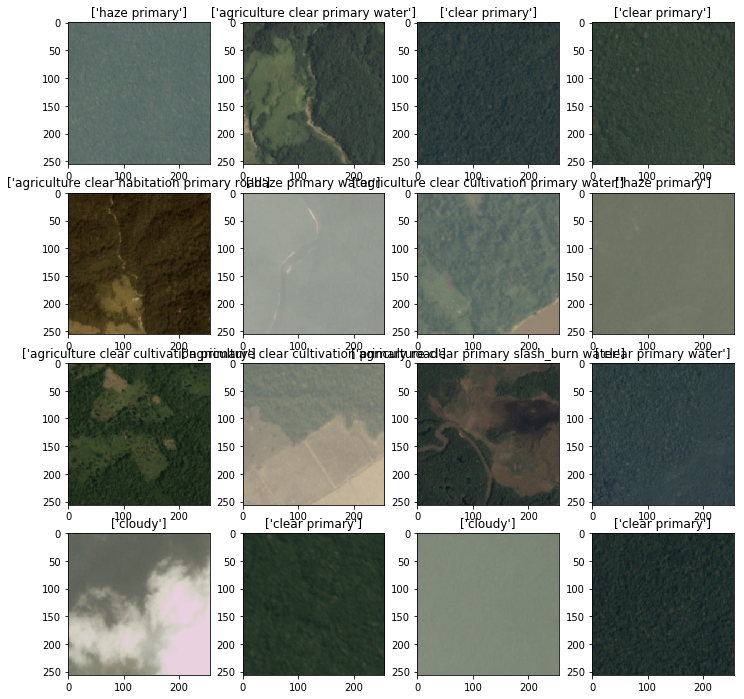

In [3]:
plt.figure(figsize=(12,12))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(plt.imread(train_path1+'train_'+str(i)+'.jpg'))
    plt.title(str(df[df.image_name == 'train_'+str(i)].tags.values))

total of 116278 non-unique tags in all training images
average number of labels per image 2.8725511993873365 

There is 17 unique labels including {'slash_burn', 'selective_logging', 'artisinal_mine', 'cloudy', 'clear', 'partly_cloudy', 'road', 'conventional_mine', 'blow_down', 'primary', 'cultivation', 'haze', 'bare_ground', 'agriculture', 'habitation', 'water', 'blooming'} 



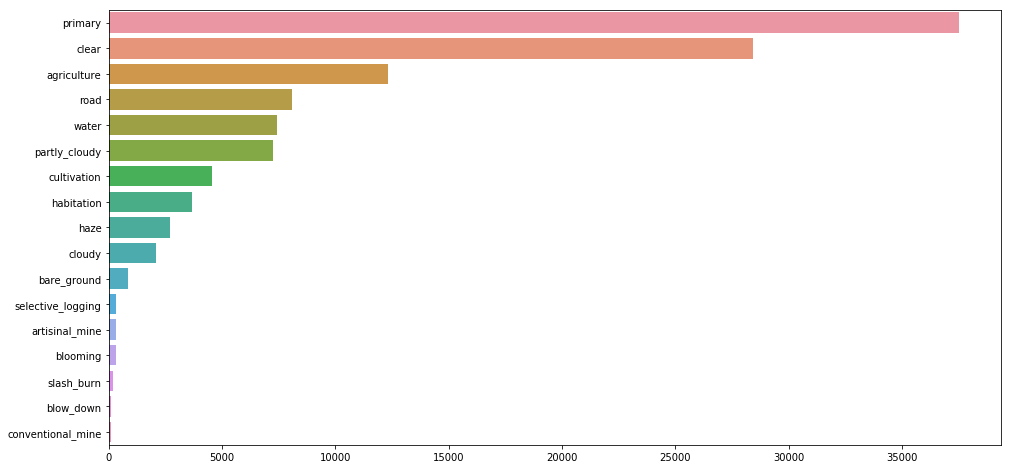

In [4]:
## View prominent tags and investigate correlations


df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {} \n'.format(1.0*len(all_tags)/df.shape[0]))

labels_set = set(all_tags)
print("There is {} unique labels including {} \n".format(len(labels_set), labels_set))

labels_s = pd.Series(all_tags).value_counts() # To sort them by count
fig, ax = plt.subplots(figsize=(16, 8))
sns.barplot(x=labels_s, y=labels_s.index, orient='h')

In [ ]:
#Display correlation between labels
labels = df['tags'].apply(lambda x: x.split(' '))
counts = defaultdict(int)
for l in labels:
    for l2 in l:
        counts[l2] += 1

com = np.zeros([len(counts)]*2)
for i, l in enumerate(list(counts.keys())):
    for i2, l2 in enumerate(list(counts.keys())):
        c = 0
        cy = 0
        for row in labels.values:
            if l in row:
                c += 1
                if l2 in row: cy += 1
        com[i, i2] = cy / c

data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
layout=go.Layout(height=800, width=800, title='Co-occurence matrix of training labels')
fig=dict(data=data, layout=layout)
py.iplot(data, filename='train-com')

In [ ]:
def remove_tag(hard):
    hard_tags=['blow_down', 'conventional_mine', 'selective_logging', 'slash_burn', 'artisinal_mine', 'blooming']
    easier_tags=hard.split()
    for i in hard_tags:
        try:
            easier_tags.remove(i)
        except:
            pass
    easier_tags=' '.join(easier_tags)
    return easier_tags
df['simpler_tags'] = df.tags.map(remove_tag)

test_labels=np.array(df_tags[15000:20000])
train_labels=np.array(df_tags[:15000])

## Weather Label Prediction

First step, we seperate weather labels from other labels. Throughout the process, we resize image to save memory when processing such huge amount of data;

Second step, randomly pick 10,000 data as training data. Then we fit the weather labels.

In [ ]:
#Seperate weather labels 
def apply_weather(weather):
    if 'partly_cloudy' in weather:
        return 'partly_cloudy'
    elif 'cloudy' in weather:
        return 'cloudy'
    elif 'haze' in weather:
        return 'haze'
    else:
        return 'clear'
df['weather'] = df.tags.map(apply_weather)
df_tags = df['weather'].tolist()
print("There are total {} weather data".format(len(df_tags)))

#Read images and resize to reduce size
weather_jpgs=[]
def read_image(image_str):
    jpg_img = io.imread(train_path1+image_str)
    norm_img=jpg_img/255
    norm_img=transform.resize(norm_img, (50,50,3))
    return norm_img.flatten()
for i in range(5000):
    weather_jpgs.append(read_image("train_"+str(i)+".jpg"))

#Set the first 30K data as training data, the rest as test data
train_labels=np.array(df_tags[:30000])
train_data=weather_jpgs[:30000]

test_labels=np.array(df_tags[30000:])
test_data=weather_jpgs[30000:]

#Random pick 10000 samples for training data
index_value = random.sample(list(enumerate(train_data)), 1000)
indexes = []
train_data_sample = []
for idx, val in index_value:
    indexes.append(idx)
    train_data_sample.append(val)

train_label_sample =[]
for i in indexes:
    train_label_sample.append(train_labels[i])

In [ ]:
#Logistics Regression

model_LG =LogisticRegression()
model_LG.fit(train_data_sample, train_label_sample)
LG_predictions=model_LG.predict(test_data)
print(classification_report(test_labels,LG_predictions))

In [ ]:
#K Means

def k_model(k,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = KNeighborsClassifier(n_neighbors=k)
    #fit per the train data
    model.fit(data_train, labels_train)
    #set by the test data
    score = model.score(data_test, labels_test)
    return (str(k)+"-NN model score: "+	str("{:.2%}".format(score)))

k_values = [1, 3]

for k in k_values:
    print(k_model(k,train_data_sample,train_label_sample,test_data,test_labels))

In [ ]:
#Naive Bayes

model_NB = MultinomialNB().fit(train_data_sample, train_label_sample)
NB_predictions = model_NB.predict(test_data)
print('accuracy', accuracy_score(test_labels, NB_predictions))

Image Processing for weather prediction:
1) Work out how to reduce image sizes - everybody ()
<br>
2) Move, Shape, Blend, Rotate
<br>
3) Try Statistical Extraction 
Maybe this is a good approach to extract stats - we can add our road information into it:
https://www.kaggle.com/the1owl/fractals-of-nature-blend-0-90050
<br>
<br>
<br>
4) Try Feature Extraction :
<br>
Roads/ Houses via Canny edging - Sai
Water and Vegetation - Elle
Cloud - Elle
Haze removal - Elle


In [ ]:
##Model Prediction - run variety of models to identify weather, using model extraction - run a bunch of models here. 
##Work out how better to separate partly cloudy - perhaps a count for cloudy pixels

weather_jpgs=np.zeros((20000,7500))
def read_image(image_str):
    jpg_img = io.imread(train_path1+image_str)
    norm_img=jpg_img/255
    norm_img=transform.resize(norm_img, (50,50,3))
    return norm_img.flatten()
for i in range(20000):
    weather_jpgs[i,:]=read_image("train_"+str(i)+".jpg")
train_data=weather_jpgs[:15000,]
test_data=weather_jpgs[15000:20000,]


def dec_tree_model(maxs,data_train,labels_train,data_test,labels_test):
    #set the model to take in the k value
    model = DecisionTreeClassifier(min_samples_leaf=10, max_depth=maxs)
    #fit per the train data
    model.fit(data_train, labels_train)
    dev_predictions2=model.predict(data_test)
    #set by the test data
#     score = model.score(data_test, labels_test)
    #print the score prettily
    return classification_report(labels_test,dev_predictions2)

#print eveyrhting
print("dev data sets")
for i in [5,10,20,50,100]:
    print(dec_tree_model(i,train_data,train_labels,test_data,test_labels))    

# Water/Road feature identification using Canny Edge detection
Next step is to stitch together GMM model for detecting "good" images of roads & water and measuring accuracy against non-filled water images or non-cloudy images.

Total number of images with water/road boundary features 3328
Correctly predicted labels 85
Accuracy is:  2.5540865384615383 %
Remaining images with especially water labels may not have boundaries/features in water or contain too much cloud.


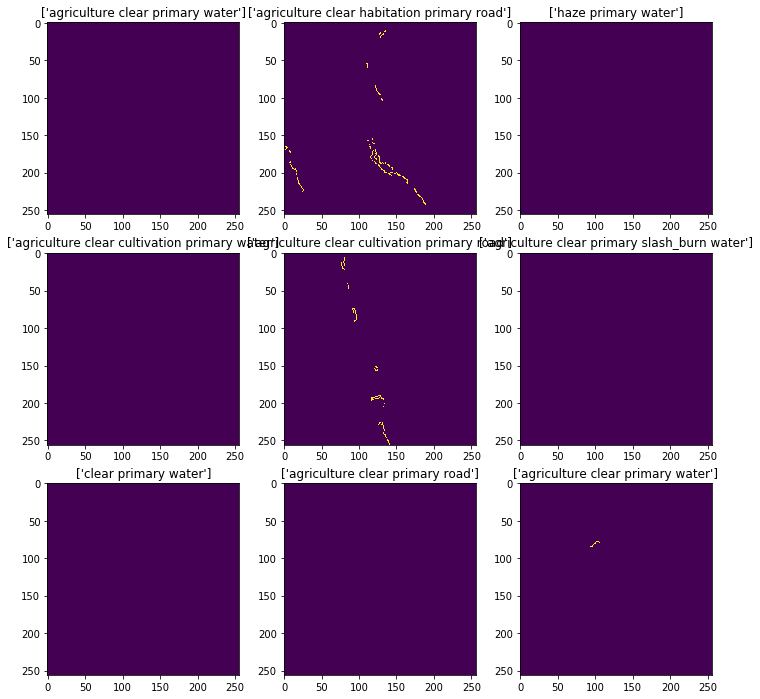

In [21]:
def road_water_canny(df):
##Testing water/road feature identification##
    #40479 images in df
    #13357 images with water and road tags in labels
    path2='train_jpg/'
    df_road_water = df[df['tags'].str.contains('road') | df['tags'].str.contains('water')]
    df_road_water_images = df_road_water['image_name'].values
    df_road_water_tags = df_road_water['tags'].values
    
    #First 10000 which contain road or water tags - for future GMM modeling
    train_road_water_images = df_road_water_images[0:2]
    train_road_water_tags = df_road_water_tags[0:2]
    #print(train_road_water_images)
    
    #First 10000
    test_df_images = df['image_name'][0:10000]
    test_df_tags = df['tags'][0:10000]
    #print(test_df_images)
    
    train_images = []
    test_images = []
    
    feature_count = 0
    positive_test_img = []
    plt.figure(figsize=(12,12))
    
    for i, test_img in enumerate(test_df_images):
        img = plt.imread(path2+test_img+'.jpg')
        
        gray_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        cannyed_image = cv2.Canny(gray_image, 100, 200)
        
        try:
            plt.subplot(3,3,i+1)
            if i < 10:
                plt.imshow(cannyed_image)
                plt.title(str(df[df.image_name == df_road_water_images[i]].tags.values))
        except:
            pass
        
        predicted_sum = sum(cannyed_image.flatten())
        
        if predicted_sum > 2.0:
            feature_count += 1
            positive_test_img.append(test_img)
        
    positive_label_count = len([i for i, j in zip(df_road_water_images, positive_test_img) if i == j])
    
    return feature_count, positive_label_count
    
feature_count, positive_label_count = road_water_canny(df)
print('Total number of images with water/road boundary features', feature_count)
print('Correctly predicted labels', positive_label_count)
print('Accuracy is: ', positive_label_count/feature_count * 100, '%')
print('Remaining images with especially water labels may not have boundaries/features in water or contain too much cloud.')

3) Try these models (this needs to be on the processed numbers) - Sai/Nick
OneVsRestClassifier
https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Multi%20label%20text%20classification.ipynb

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Binary Relevance Chain 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression

Classifier CHains 
Gaussian NB
Logsitic Regression

K-NN
Naive Bayes
Decision Trees
Random forests
Logistic Regression
Adapted Algorithms
Multi-label nearest Neigbors
Decisions Trees
Random Forests
Neural Nets



Image Processing - how do we make the images smaller, easier size agnostic

Out of scope
Try Convultional Neural Networks
Ask June for help in Set-up